In [0]:
from google.colab import drive
drive.mount('/content/drive')

root_dir = '/content/drive/My Drive/'
base_dir = '/content/drive/My Drive/fastai-v3'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Recognize Indian Currency

In [0]:
!pip install tf-nightly-gpu-2.0-preview
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
os.listdir(base_dir)

['Pest-Recognition-Dataset',
 'Glasses-NoGlasses',
 'kaggle.json',
 'Indian-Currency-Dataset',
 'Currency-Dataset']

## Setup Input Pipeline

In [0]:
path_data = base_dir + '/Indian-Currency-Dataset/train'
path_test = base_dir + '/Indian-Currency-Dataset/test'
path_aug = base_dir + '/Indian-Currency-Dataset/train/augmented_images'
os.listdir(path_data)

['models',
 '500',
 '50',
 '100',
 '20',
 '10',
 '2000',
 '200',
 'none',
 '5',
 'export(19 8).pkl',
 'save',
 'labels.txt',
 'augmented_images']

In [0]:
# ?tf.keras.preprocessing.image.ImageDataGenerator.flow_from_directory

In [0]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.2,1.5],
    fill_mode = 'nearest',
    vertical_flip = True,
    validation_split=0.2)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    path_data,
    classes = ['none', '5', '10', '20', '50', '100', '200', '500', '2000'],
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    seed = 1,
    save_to_dir = path_aug,
    save_prefix = 'tr-1',
    save_format = 'jpg',
    batch_size=BATCH_SIZE, 
    subset='training')


val_generator = datagen.flow_from_directory(
    path_data,
    classes = ['none', '5', '10', '20', '50', '100', '200', '500', '2000'],
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    seed = 0,
    subset='validation')

test_generator = test_datagen.flow_from_directory(path_test,
                                                  target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                  batch_size=BATCH_SIZE)

Found 4258 images belonging to 9 classes.
Found 1059 images belonging to 9 classes.
Found 294 images belonging to 9 classes.


In [0]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights= None)

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(9, activation='softmax')
])

In [0]:
model.load_weights(path_data + '/save/fine_tuning/save-weights-1-scratch.h5')

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
activation (Activation)      (None, 5, 5, 32)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 5, 32)          128       
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 9)                 2

### Train the model

<!-- TODO(markdaoust): delete steps_per_epoch in TensorFlow r1.14/r2.0 -->

In [0]:
epochs = 5

history = model.fit_generator(train_generator,
                    epochs = epochs,
                    validation_data = val_generator)

Epoch 1/5


W0901 07:00:08.917858 140391508227968 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/math_grad.py:1423: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


66/66 [==============================] - 2024s 31s/step - loss: 2.1120 - categorical_accuracy: 0.1738 - val_loss: 7.0995 - val_categorical_accuracy: 0.1173
Epoch 2/5
66/66 [==============================] - 80s 1s/step - loss: 1.9115 - categorical_accuracy: 0.2539 - val_loss: 3.2596 - val_categorical_accuracy: 0.1173
Epoch 3/5
66/66 [==============================] - 84s 1s/step - loss: 1.8274 - categorical_accuracy: 0.2798 - val_loss: 3.2329 - val_categorical_accuracy: 0.1250
Epoch 4/5
66/66 [==============================] - 89s 1s/step - loss: 1.6419 - categorical_accuracy: 0.3458 - val_loss: 4.2940 - val_categorical_accuracy: 0.1346
Epoch 5/5
66/66 [==============================] - 93s 1s/step - loss: 1.5278 - categorical_accuracy: 0.4012 - val_loss: 5.2854 - val_categorical_accuracy: 0.1269


In [0]:
model.save_weights(path_data + '/save/fine_tuning/save-weights-1-scratch.h5')

In [0]:
epochs = 5

history = model.fit_generator(train_generator,
                    epochs=epochs,
                    validation_data=val_generator)

Epoch 1/5


InternalError: ignored

In [0]:
model.save_weights(path_data + '/save/fine_tuning/save-weights-2-scratch.h5')

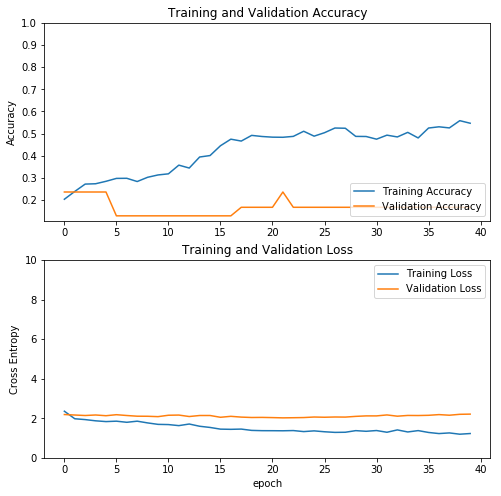

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Testing

In [0]:
Y_pred = model.predict_generator(test_generator)
Y_pred.shape

(277, 9)

In [0]:
y_pred = np.argmax(Y_pred, axis = 1)
y_pred.shape

(277,)

In [0]:
print(confusion_matrix(test_generator.classes, y_pred))

[[ 0 57  0  0  0  0  0  0]
 [ 0 62  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0]
 [ 0 37  0  0  0  0  0  0]
 [ 0 24  0  0  0  0  0  0]
 [ 0 36  0  0  0  0  0  0]
 [ 0 22  0  0  0  0  0  0]
 [ 0 29  0  0  0  0  0  0]]


In [0]:
print(classification_report(test_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        57
           1       0.22      1.00      0.37        62
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        37
           5       0.00      0.00      0.00        24
           6       0.00      0.00      0.00        36
           7       0.00      0.00      0.00        22
           8       0.00      0.00      0.00        29

    accuracy                           0.22       277
   macro avg       0.03      0.12      0.05       277
weighted avg       0.05      0.22      0.08       277



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Convert to TFLite

In [0]:
saved_model_dir = path_data + '/save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open(saved_model_dir + '/model-3.tflite', 'wb') as f:
  f.write(tflite_model)

Download the converted model and labels

In [0]:
from google.colab import files

files.download('model.tflite')
files.download('labels.txt')

In [0]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()